In [1]:
import pandas as pd
import numpy as np
import os, time, stat, io, glob, pickle
from scipy.stats import gamma, norm
from sklearn.linear_model import LinearRegression

from IPython.core.display import display, HTML

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('fivethirtyeight')
import plotly.io as pio

%load_ext autoreload
%autoreload 2
from covid_data_helper import *
from coronita_chart_helper import *
from coronita_model_helper import *

from matplotlib.backends.backend_pdf import PdfPages
from PyPDF2 import PdfFileWriter, PdfFileReader

def footnote_str_maker():
    footnote_str = 'Author: Michael Donnelly | twtr: @donnellymjd | www.covidoutlook.info\nChart created on {}'.format(
        pd.Timestamp.today().strftime("%d %b, %Y at %I:%M %p"))
    return footnote_str

def add_plotly_footnote(fig):
    fig.update_layout(
                  annotations=[
                      dict(x = 0, y = -0.06, font_size=10, showarrow=False,
                           xref='paper', yref='paper',
                           xanchor='left', yanchor='auto', xshift=0, yshift=0,
                           text='Author: Michael Donnelly | twtr: <a href="https://twitter.com/donnellymjd">@donnellymjd</a> | <a href="http://{0}">{0}</a>'.format(
                           'www.michaeldonnel.ly')
                          ),
                      dict(x = 0, y = -0.09, font_size=10, showarrow=False,
                           xref='paper', yref='paper',
                           xanchor='left', yanchor='auto', xshift=0, yshift=0,
                           text='Chart created on {}'.format(pd.Timestamp.today().strftime("%d %b %Y"))
                          )
                  ]
                 )
    return fig

from my_can_apikey import can_apikey


## Vaccine Administration and Delivery Data from COVID Act Now

In [2]:
df_can_raw = pd.read_csv(f'https://api.covidactnow.org/v2/states.timeseries.csv?apiKey={can_apikey}')
df_can_raw.head()

,date,country,state,county,fips,lat,long,locationId,actuals.cases,actuals.deaths,...,metrics.infectionRate,metrics.infectionRateCI90,metrics.icuHeadroomRatio,metrics.icuHeadroomDetails,metrics.icuCapacityRatio,riskLevels.overall,metrics.vaccinationsInitiatedRatio,metrics.vaccinationsCompletedRatio,actuals.newDeaths,actuals.vaccinesAdministered
0,2020-03-01,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
1,2020-03-02,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
2,2020-03-03,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
3,2020-03-04,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
4,2020-03-05,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN


In [3]:
df_can = df_can_raw.copy()

df_can['dt'] = pd.to_datetime(df_can['date'])
df_can = df_can.set_index(['state','dt'])

df_can.head()


date country  county  fips  lat  long  \
state dt                                                        
AK    2020-03-01  2020-03-01      US     NaN     2  NaN   NaN   
      2020-03-02  2020-03-02      US     NaN     2  NaN   NaN   
      2020-03-03  2020-03-03      US     NaN     2  NaN   NaN   
      2020-03-04  2020-03-04      US     NaN     2  NaN   NaN   
      2020-03-05  2020-03-05      US     NaN     2  NaN   NaN   

                          locationId  actuals.cases  actuals.deaths  \
state dt                                                              
AK    2020-03-01  iso1:us#iso2:us-ak            NaN             NaN   
      2020-03-02  iso1:us#iso2:us-ak            NaN             NaN   
      2020-03-03  iso1:us#iso2:us-ak            NaN             NaN   
      2020-03-04  iso1:us#iso2:us-ak            NaN             NaN   
      2020-03-05  iso1:us#iso2:us-ak            NaN             NaN   

                  actuals.positiveTests  ...  metrics.infectionRate  \
state dt                                 ...                          
AK    2020-03-01                    NaN  ...                    NaN   
      2020-03-02                    NaN  ...                    NaN   
      2020-03-03                    NaN  ...                    NaN   
      2020-03-04                    NaN  ...                    NaN   
      2020-03-05                    NaN  ...                    NaN   

                  metrics.infectionRateCI90  metrics.icuHeadroomRatio  \
state dt                                                                
AK    2020-03-01                        NaN                       NaN   
      2020-03-02                        NaN                       NaN   
      2020-03-03                        NaN                       NaN   
      2020-03-04                        NaN                       NaN   
      2020-03-05                        NaN                       NaN   

                  metrics.icuHeadroomDetails  metrics.icuCapacityRatio  \
state dt                                                                 
AK    2020-03-01                         NaN                       NaN   
      2020-03-02                         NaN                       NaN   
      2020-03-03                         NaN                       NaN   
      2020-03-04                         NaN                       NaN   
      2020-03-05                         NaN                       NaN   

                  riskLevels.overall  metrics.vaccinationsInitiatedRatio  \
state dt                                                                   
AK    2020-03-01                   0                                 NaN   
      2020-03-02                   0                                 NaN   
      2020-03-03                   0                                 NaN   
      2020-03-04                   0                                 NaN   
      2020-03-05                   0                                 NaN   

                  metrics.vaccinationsCompletedRatio  actuals.newDeaths  \
state dt                                                                  
AK    2020-03-01                                 NaN                NaN   
      2020-03-02                                 NaN                NaN   
      2020-03-03                                 NaN                NaN   
      2020-03-04                                 NaN                NaN   
      2020-03-05                                 NaN                NaN   

                  actuals.vaccinesAdministered  
state dt                                        
AK    2020-03-01                           NaN  
      2020-03-02                           NaN  
      2020-03-03                           NaN  
      2020-03-04                           NaN  
      2020-03-05                           NaN  

[5 rows x 38 columns]

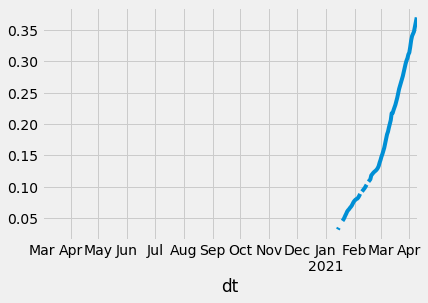

In [4]:
df_can.loc['NY','metrics.vaccinationsInitiatedRatio'].plot()

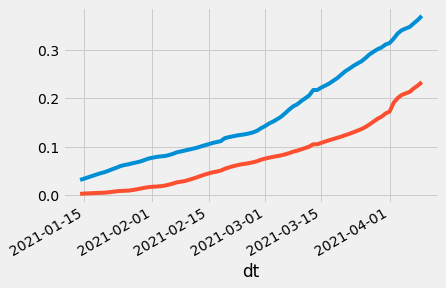

In [12]:
df_can.loc['NY','metrics.vaccinationsInitiatedRatio'].dropna().plot()
df_can.loc['NY','metrics.vaccinationsCompletedRatio'].dropna().plot()

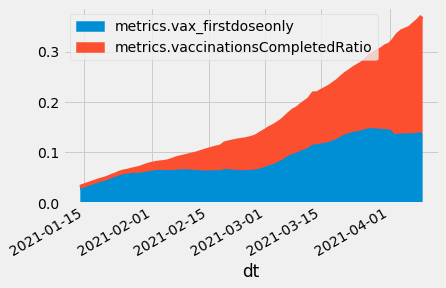

In [19]:
df_can['metrics.vax_firstdoseonly'] = df_can['metrics.vaccinationsInitiatedRatio'].sub(
    df_can['metrics.vaccinationsCompletedRatio'])
ax = df_can.loc['NY',['metrics.vax_firstdoseonly','metrics.vaccinationsCompletedRatio']
               ].dropna().plot(kind='area', stacked=True)
# df_can.loc['NY','metrics.vaccinationsCompletedRatio'].dropna().plot(ax=ax, kind='area', stacked=True)

In [6]:
df_can.columns


Index(['date', 'country', 'county', 'fips', 'lat', 'long', 'locationId',
       'actuals.cases', 'actuals.deaths', 'actuals.positiveTests',
       'actuals.negativeTests', 'actuals.contactTracers',
       'actuals.hospitalBeds.capacity',
       'actuals.hospitalBeds.currentUsageTotal',
       'actuals.hospitalBeds.currentUsageCovid',
       'actuals.hospitalBeds.typicalUsageRate', 'actuals.icuBeds.capacity',
       'actuals.icuBeds.currentUsageTotal',
       'actuals.icuBeds.currentUsageCovid', 'actuals.icuBeds.typicalUsageRate',
       'actuals.newCases', 'actuals.vaccinesDistributed',
       'actuals.vaccinationsInitiated', 'actuals.vaccinationsCompleted',
       'metrics.testPositivityRatio', 'metrics.testPositivityRatioDetails',
       'metrics.caseDensity', 'metrics.contactTracerCapacityRatio',
       'metrics.infectionRate', 'metrics.infectionRateCI90',
       'metrics.icuHeadroomRatio', 'metrics.icuHeadroomDetails',
       'metrics.icuCapacityRatio', 'riskLevels.overall',
      

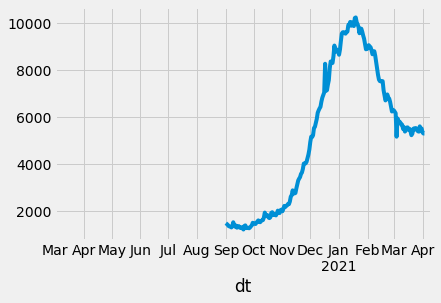

In [7]:
df_can.loc['NY','actuals.hospitalBeds.currentUsageCovid'].plot()

### County Level

In [19]:
df_counties = get_complete_county_data()

Got NYS DOH data
Got Census Data
Got NYT county level data.
Got NYC DOH data
Got Google Movement Data
Got Complete County Data


In [35]:
this = 'NY'
df_counties.query(f"state=='{this}'")[['pop2019', 'cases', 'deaths', 'cases_per100k']]

pop2019     cases  deaths  cases_per100k
dt         state county      fips                                            
2020-02-15 NY    Albany      36001       NaN       NaN     NaN            NaN
                 Allegany    36003       NaN       NaN     NaN            NaN
                 Bronx       36005       NaN       NaN     NaN            NaN
                 Broome      36007       NaN       NaN     NaN            NaN
                 Cattaraugus 36009       NaN       NaN     NaN            NaN
...                                      ...       ...     ...            ...
2021-04-20 NY    Washington  36115   61204.0    2870.0    55.0    4689.235998
                 Wayne       36117   89918.0    5285.0    67.0    5877.577348
                 Westchester 36119  967506.0  126093.0  2246.0   13032.787394
                 Wyoming     36121   39859.0    3268.0    51.0    8198.901126
                 Yates       36123   24913.0    1110.0    26.0    4455.505158

[26685 rows x 4 columns]

In [22]:
df_cancounties_raw = pd.read_csv(f'https://api.covidactnow.org/v2/counties.timeseries.csv?apiKey={can_apikey}')

In [39]:
df_cancounties = df_cancounties_raw.copy()

df_cancounties['dt'] = pd.to_datetime(df_cancounties['date'])
df_cancounties['fips'] = df_cancounties['fips'].astype(str).replace('\.0', '', regex=True).str.zfill(5)

df_cancounties = df_cancounties.set_index(['state','fips','dt'])

df_cancounties = df_cancounties[['actuals.cases',
       'actuals.deaths', 'actuals.positiveTests', 'actuals.negativeTests',
       'actuals.contactTracers', 'actuals.hospitalBeds.capacity',
       'actuals.hospitalBeds.currentUsageTotal',
       'actuals.hospitalBeds.currentUsageCovid',
       'actuals.hospitalBeds.typicalUsageRate', 'actuals.icuBeds.capacity',
       'actuals.icuBeds.currentUsageTotal',
       'actuals.icuBeds.currentUsageCovid', 'actuals.icuBeds.typicalUsageRate',
       'actuals.newCases', 'actuals.vaccinesDistributed',
       'actuals.vaccinationsInitiated', 'actuals.vaccinationsCompleted',
       'metrics.testPositivityRatio', 'metrics.testPositivityRatioDetails',
       'metrics.caseDensity', 'metrics.contactTracerCapacityRatio',
       'metrics.infectionRate', 'metrics.infectionRateCI90',
       'metrics.icuHeadroomRatio', 'metrics.icuHeadroomDetails',
       'metrics.icuCapacityRatio', 'riskLevels.overall',
       'metrics.vaccinationsInitiatedRatio',
       'metrics.vaccinationsCompletedRatio', 'actuals.newDeaths',
       'actuals.vaccinesAdministered']]
df_cancounties

actuals.cases  actuals.deaths  actuals.positiveTests  \
state fips  dt                                                                 
AK    02013 2020-01-22            NaN             NaN                    NaN   
            2020-01-23            NaN             NaN                    NaN   
            2020-01-24            NaN             NaN                    NaN   
            2020-01-25            NaN             NaN                    NaN   
            2020-01-26            NaN             NaN                    NaN   
...                               ...             ...                    ...   
WY    56045 2021-04-17          646.0             5.0                    NaN   
            2021-04-18          646.0             5.0                    NaN   
            2021-04-19          647.0             5.0                    NaN   
            2021-04-20          647.0             5.0                    NaN   
            2021-04-21            NaN             NaN                    NaN   

                        actuals.negativeTests  actuals.contactTracers  \
state fips  dt                                                          
AK    02013 2020-01-22                    NaN                     NaN   
            2020-01-23                    NaN                     NaN   
            2020-01-24                    NaN                     NaN   
            2020-01-25                    NaN                     NaN   
            2020-01-26                    NaN                     NaN   
...                                       ...                     ...   
WY    56045 2021-04-17                    NaN                     NaN   
            2021-04-18                    NaN                     NaN   
            2021-04-19                    NaN                     NaN   
            2021-04-20                    NaN                     NaN   
            2021-04-21                    NaN                     NaN   

                        actuals.hospitalBeds.capacity  \
state fips  dt                                          
AK    02013 2020-01-22                            NaN   
            2020-01-23                            NaN   
            2020-01-24                            NaN   
            2020-01-25                            NaN   
            2020-01-26                            NaN   
...                                               ...   
WY    56045 2021-04-17                            NaN   
            2021-04-18                            NaN   
            2021-04-19                            NaN   
            2021-04-20                            NaN   
            2021-04-21                            NaN   

                        actuals.hospitalBeds.currentUsageTotal  \
state fips  dt                                                   
AK    02013 2020-01-22                                     NaN   
            2020-01-23                                     NaN   
            2020-01-24                                     NaN   
            2020-01-25                                     NaN   
            2020-01-26                                     NaN   
...                                                        ...   
WY    56045 2021-04-17                                     NaN   
            2021-04-18                                     NaN   
            2021-04-19                                     NaN   
            2021-04-20                                     NaN   
            2021-04-21                                     NaN   

                        actuals.hospitalBeds.currentUsageCovid  \
state fips  dt                                                   
AK    02013 2020-01-22                                     NaN   
            2020-01-23                                     NaN   
            2020-01-24                                     NaN   
            2020-01-25                                     NaN   
            2020-01-26              

/Users/mdonnelly/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


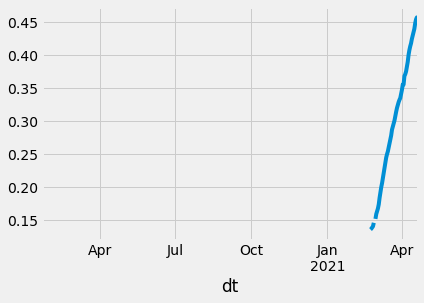

In [24]:
df_cancounties.loc[('NY','Monroe County'),'metrics.vaccinationsInitiatedRatio'].plot()

In [38]:
df_cancounties

date country   fips  lat  long  \
state county                 dt                                                 
AK    Aleutians East Borough 2020-01-22  2020-01-22      US   2013  NaN   NaN   
                             2020-01-23  2020-01-23      US   2013  NaN   NaN   
                             2020-01-24  2020-01-24      US   2013  NaN   NaN   
                             2020-01-25  2020-01-25      US   2013  NaN   NaN   
                             2020-01-26  2020-01-26      US   2013  NaN   NaN   
...                                             ...     ...    ...  ...   ...   
WY    Weston County          2021-04-17  2021-04-17      US  56045  NaN   NaN   
                             2021-04-18  2021-04-18      US  56045  NaN   NaN   
                             2021-04-19  2021-04-19      US  56045  NaN   NaN   
                             2021-04-20  2021-04-20      US  56045  NaN   NaN   
                             2021-04-21  2021-04-21      US  56045  NaN   NaN   

                                                            locationId  \
state county                 dt                                          
AK    Aleutians East Borough 2020-01-22  iso1:us#iso2:us-ak#fips:02013   
                             2020-01-23  iso1:us#iso2:us-ak#fips:02013   
                             2020-01-24  iso1:us#iso2:us-ak#fips:02013   
                             2020-01-25  iso1:us#iso2:us-ak#fips:02013   
                             2020-01-26  iso1:us#iso2:us-ak#fips:02013   
...                                                                ...   
WY    Weston County          2021-04-17  iso1:us#iso2:us-wy#fips:56045   
                             2021-04-18  iso1:us#iso2:us-wy#fips:56045   
                             2021-04-19  iso1:us#iso2:us-wy#fips:56045   
                             2021-04-20  iso1:us#iso2:us-wy#fips:56045   
                             2021-04-21  iso1:us#iso2:us-wy#fips:56045   

                                         actuals.cases  actuals.deaths  \
state county                 dt                                          
AK    Aleutians East Borough 2020-01-22            NaN             NaN   
                             2020-01-23            NaN             NaN   
                             2020-01-24            NaN             NaN   
                             2020-01-25            NaN             NaN   
                             2020-01-26            NaN             NaN   
...                                                ...             ...   
WY    Weston County          2021-04-17          646.0             5.0   
                             2021-04-18          646.0             5.0   
                             2021-04-19          647.0             5.0   
                             2021-04-20          647.0             5.0   
                             2021-04-21            NaN             NaN   

                                         actuals.positiveTests  \
state county                 dt                                  
AK    Aleutians East Borough 2020-01-22                    NaN   
                             2020-01-23                    NaN   
                             2020-01-24                    NaN   
                             2020-01-25                    NaN   
                             2020-01-26                    NaN   
...                                                        ...   
WY    Weston County          2021-04-17                    NaN   
                             2021-04-18                    NaN   
                             2021-04-19                    NaN   
                             2021-04-20                    NaN   
                             2021-04-21                    NaN   

                                         actuals.negativeTests  ...  \
state county                 dt                                 ...   
AK    Aleutians East Borough 2020-01-22                    NaN  ..

In [37]:
df_cancounties.columns

Index(['date', 'country', 'fips', 'lat', 'long', 'locationId', 'actuals.cases',
       'actuals.deaths', 'actuals.positiveTests', 'actuals.negativeTests',
       'actuals.contactTracers', 'actuals.hospitalBeds.capacity',
       'actuals.hospitalBeds.currentUsageTotal',
       'actuals.hospitalBeds.currentUsageCovid',
       'actuals.hospitalBeds.typicalUsageRate', 'actuals.icuBeds.capacity',
       'actuals.icuBeds.currentUsageTotal',
       'actuals.icuBeds.currentUsageCovid', 'actuals.icuBeds.typicalUsageRate',
       'actuals.newCases', 'actuals.vaccinesDistributed',
       'actuals.vaccinationsInitiated', 'actuals.vaccinationsCompleted',
       'metrics.testPositivityRatio', 'metrics.testPositivityRatioDetails',
       'metrics.caseDensity', 'metrics.contactTracerCapacityRatio',
       'metrics.infectionRate', 'metrics.infectionRateCI90',
       'metrics.icuHeadroomRatio', 'metrics.icuHeadroomDetails',
       'metrics.icuCapacityRatio', 'riskLevels.overall',
       'metrics.vaccina

## Vaccine Hesitancy Data from HHS
https://data.cdc.gov/stories/s/Vaccine-Hesitancy-for-COVID-19/cnd2-a6zw

We use the HPS survey question, “Once a vaccine to prevent COVID-19 is available to you, would you…get a vaccine?”, which provides the following options: 1) “definitely get a vaccine”; 2) “probably get a vaccine”; 3) “probably not get a vaccine”; 4) “definitely not get a vaccine”. COVID-19 vaccine hesitancy was defined as follows:
 - hesitancy: includes survey responses indicating that they would “probably not” or “definitely not” receive a COVID-19 vaccine when available.
 - strong hesitancy: include only survey responses indicating that they would “definitely not” receive a COVID-19 vaccine when available.

In [7]:
df_vax_hes = pd.read_csv('./data/Vaccine_Hesitancy_for_COVID-19__County_and_local_estimates.csv')
newcols = {
    'FIPS Code':'fips',
    'County Name':'county',
    'State Code':'state',
    'Estimated hesitant':'est_vax_hes',
    'Estimated strongly hesitant':'est_vax_hes_strong'
}
df_vax_hes = df_vax_hes[newcols.keys()].rename(columns = newcols)

In [15]:
df_vax_hes['fips'] = df_vax_hes['fips'].astype(str).replace('\.0', '', regex=True).str.zfill(5)
df_census = get_census_pop()
df_vax_hes = pd.merge(df_vax_hes, df_census[['fips','pop2019']], on='fips')
df_vax_hes['est_vax_hes_pop'] = df_vax_hes['est_vax_hes'] * df_vax_hes['pop2019']
df_vax_hes['est_vax_hes_strong_pop'] = df_vax_hes['est_vax_hes_strong'] * df_vax_hes['pop2019']
df_vax_hes

Got Census Data


,fips,county,state,est_vax_hes,est_vax_hes_strong,pop2019,est_vax_hes_pop,est_vax_hes_strong_pop
0,01123,"Tallapoosa County, Alabama",AL,0.23,0.12,40367,9284.41,4844.04
1,01121,"Talladega County, Alabama",AL,0.23,0.11,79978,18394.94,8797.58
2,01131,"Wilcox County, Alabama",AL,0.23,0.11,10373,2385.79,1141.03
3,01129,"Washington County, Alabama",AL,0.23,0.11,16326,3754.98,1795.86
4,01133,"Winston County, Alabama",AL,0.22,0.11,23629,5198.38,2599.19
...,...,...,...,...,...,...,...,...
3137,55079,"Milwaukee County, Wisconsin",WI,0.18,0.11,945726,170230.68,104029.86
3138,55121,"Trempealeau County, Wisconsin",WI,0.18,0.10,29649,5336.82,2964.90
3139,56001,"Albany County, Wyoming",WY,0.30,0.16,38880,11664.00,6220.80
3140,55067,"Langlade County, Wisconsin",WI,0.17,0.10,19189,3262.13,1918.90


In [48]:
df_vax_hes_state = df_vax_hes.groupby('state').sum()[['pop2019','est_vax_hes_pop','est_vax_hes_strong_pop']]
df_vax_hes_state['est_vax_hes'] = df_vax_hes_state['est_vax_hes_pop'] / df_vax_hes_state['pop2019']
df_vax_hes_state['est_vax_hes_strong'] = df_vax_hes_state['est_vax_hes_strong_pop'] / df_vax_hes_state['pop2019']
df_vax_hes_state

,pop2019,est_vax_hes_pop,est_vax_hes_strong_pop,est_vax_hes,est_vax_hes_strong
state,,,,,
AK,731545,148908.75,66315.78,0.203554,0.090652
AL,4903185,1051278.70,509013.72,0.214407,0.103813
AR,3017804,639032.98,380982.99,0.211754,0.126245
AZ,7278717,1277251.95,754760.02,0.175478,0.103694
CA,39512223,4310092.51,1663727.33,0.109083,0.042107
CO,5758736,886368.89,336016.72,0.153917,0.058349
CT,3565287,360630.65,143779.30,0.101151,0.040328
DC,705749,70574.90,28229.96,0.100000,0.040000
DE,973764,129670.65,40758.42,0.133164,0.041857
